In [1]:
import random
import math

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Stałe

In [2]:
SHOP_RANGE = 8
POPULATION_SIZE = 44
GENOTYPE_SIZE = 15
IMAGE = Image.open('input.png')
IMAGE_SIZE = IMAGE.size

## Funkcje pomocnicze

In [3]:
# generowanie losowej populacji
def random_population():
    return [
        [
            (random.randint(0, IMAGE_SIZE[0]), random.randint(0, IMAGE_SIZE[1]))
            for _ in range(GENOTYPE_SIZE)
        ]
        for _ in range(POPULATION_SIZE)
    ]

In [4]:
# rysowanie zasiegu sklepow na obrazie
def draw_shops(shops, fill='red', outline='red'):
        img = IMAGE.copy()
        draw = ImageDraw.Draw(img)

        for x, y in shops:
            draw.ellipse(
                (x - SHOP_RANGE, y - SHOP_RANGE, x + SHOP_RANGE, y + SHOP_RANGE),
                fill=fill,
                outline = outline
            )
    
        return img

In [5]:
# zliczanie pikseli danego koloru, domyslnie czarny
def count_pixels(img, color=(0, 0, 0)):
    return sum(1 for p in img.getdata() if p == color)

In [6]:
# wyznaczanie wartosci fitness jako ilosc czarnych pikseli, im mniej tym lepiej
def fitness(a):
    return count_pixels(draw_shops(a))

In [7]:
# selekcja: calkowicie losowy
def select_roulette(population):
    return random.choice(population)

# selekcja: n-ty wg rankingu po fukncji fitness
def select_ranking(population, pos=0):
    return sorted(population, key=fitness)[pos]
    
# selekcja: najlepszy z k losowych
def select_tournament(population, k=2):
    return select_ranking(random.choices(population, k=k))

In [8]:
# funkcja ktora losuje kolo i zwraca funckje mowiaca czy punkt nalezy do kola czy nie
def splitter_circle():
    
    # losujemy duze kolo o promieniu nie wiekszym niz polowa rozmiaru obrazka
    center = (random.randint(0, IMAGE_SIZE[0]), random.randint(0, IMAGE_SIZE[1]))
    radius = random.randint(0, min(*IMAGE_SIZE) // 2)
    
    # zwracamy funkcje czy nalezy do tego okregu
    return lambda x: abs(x[0] - center[0]) + abs(x[1] - center[1]) <= radius

# funkcja ktora losuje linie i zwraca funckje mowiaca czy punkt lezy pod linia czy nad
def splitter_line():
    
    # losujemy linie przechodzaca przez srodek
    a = math.tan(random.uniform(0, 2 * math.pi))
    b = IMAGE_SIZE[1] / 2 - a * IMAGE_SIZE[0] / 2
    
    # zwracamy funkcje czy punkt jest pod linia
    return lambda x: x[1] < a * x[0] + b

# krzyrzowanie przy uzyciu podaje funkcji dzielacej
def cross(a, b, splitter):
    
    # dzielimy punkty przy uzyciu podej funkcji
    a1 = [x for x in a if splitter(x)]
    a2 = [x for x in a if not splitter(x)]
    b1 = [x for x in b if splitter(x)]
    b2 = [x for x in b if not splitter(x)]
    
    # tworzymy nowe osobniki
    n1 = a1 + b2
    n2 = b1 + a2
    
    # skracamy zbyt dlugie osobniki
    while len(n1) > GENOTYPE_SIZE:
        del n1[random.randrange(0, len(n1))]

    while len(n2) > GENOTYPE_SIZE:
        del n2[random.randrange(0, len(n2))]

    # wydluzamy zbyt krotkie
    while len(n1) < GENOTYPE_SIZE:
        x = random.choice(b1)
        if x not in n1:
            n1.append(x)

    while len(n2) < GENOTYPE_SIZE:
        x = random.choice(a1)
        if x not in n2:
            n2.append(x)
    
    return n1, n2

In [9]:
# mutacja: zamiana jednego punktu na nowy losowy
def mutate_random(a):
    a[random.randrange(0, len(a))] = (random.randint(0, IMAGE_SIZE[0]), random.randint(0, IMAGE_SIZE[1]))
    return a

# mutacja: przesuniecie jednego punktu o losowy wektor
def mutate_translate(a, max_move=20):
    i = random.randrange(0, len(a))
    a[i] = (a[i][0] + random.randint(-max_move, max_move), a[i][1] + random.randint(-max_move, max_move))
    return a

## Główny program

In [10]:
# symulujemy dana liczbe pokolen wykonujac dana liczbe krzyzowan, korzystajac z podanych funkcji:
#     wybor rodszicow, podzial podczas krzyzowania, mutowanie
def simulate(n_generations, n_crosses, p_mutate, selection, splitter, mutation):
    
    # dane pomiarowe
    data_best = []
    data_worst = []
    data_average = []
    
    # losowanie populacji
    population = random_population()
    
    # pokolenia
    for i in range(n_generations):
        
        # krzyzujemy i dodajemy powstale do populacji
        for _ in range(n_crosses):
            a = selection(population)
            b = selection(population)
            population += list(cross(a, b, splitter()))
        
        # mutujemy losowe
        for x in population:
            if random.uniform(0, 1) < p_mutate:
                mutation(x)
        
        # wybieramy najlepsze jako nowa populacje
        population = sorted(population, key=fitness)[:POPULATION_SIZE]
        
        # zapisujemy dane pomiarowe
        data_best.append(fitness(population[0]))
        data_worst.append(fitness(population[-1]))
        data_average.append(sum(fitness(x) for x in population) / len(population))
    
    # rysowanie grafu
    plt.plot(data_best, label='najlepszy', color='green')
    plt.plot(data_worst, label='najgorszy', color='red')
    plt.plot(data_average, label='srednia', color='grey')
    plt.legend()
    plt.xlabel('pokolenia')
    plt.ylabel('fitness')
    plt.show()
    
    # zwracamy najlepszego
    return population[0]

## Analiza

Pokolenia: **100**  
Krzyżówki na pokolenie: **12**  
Szansa na mutacje: **20%**  
Wybór rodziców: **lepszy z dwóch losowych**  
Podział podczas krzyżowania: **względem okręgu**  
Mutacja: **dodawanie wektora**  

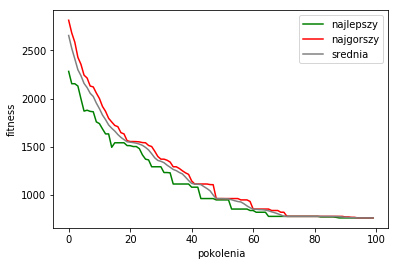

[(112, 27), (77, 61), (53, 47), (41, 24), (69, 29), (87, 71), (89, 63), (109, 44), (19, 86), (23, 40), (68, 76), (37, 40), (24, 25), (11, 13), (7, 28)]


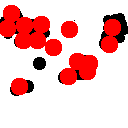

In [11]:
x = simulate(100, 12, 0.2, select_tournament, splitter_circle, mutate_translate)
print(x)
draw_shops(x)

Pokolenia: **200**  
Krzyżówki na pokolenie: 12  
Szansa na mutacje: 20%  
Wybór rodziców: lepszy z dwóch losowych  
Podział podczas krzyżowania: względem okręgu  
Mutacja: dodawanie wektora  

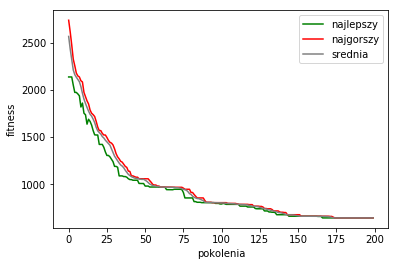

[(19, 88), (66, 75), (67, 27), (121, 36), (107, 39), (111, 23), (80, 61), (86, 69), (54, 47), (40, 38), (43, 22), (26, 23), (10, 16), (8, 29), (24, 40)]


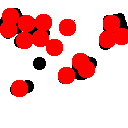

In [12]:
x = simulate(200, 12, 0.2, select_tournament, splitter_circle, mutate_translate)
print(x)
draw_shops(x)

Pokolenia: 100  
Krzyżówki na pokolenie: 12  
Szansa na mutacje: 20%  
Wybór rodziców: **losowy**  
Podział podczas krzyżowania: względem okręgu  
Mutacja: dodawanie wektora  

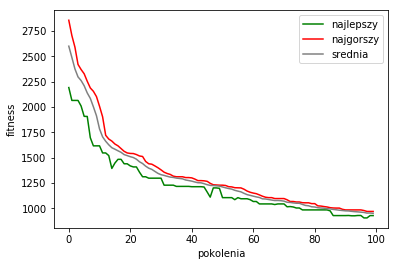

[(32, 66), (22, 27), (16, 36), (106, 38), (68, 73), (83, 70), (55, 47), (35, 27), (41, 36), (10, 19), (111, 22), (120, 28), (10, 87), (22, 91), (82, 61)]


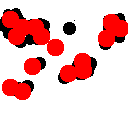

In [13]:
x = simulate(100, 12, 0.2, select_roulette, splitter_circle, mutate_translate)
print(x)
draw_shops(x)

Pokolenia: 100  
Krzyżówki na pokolenie: 12  
Szansa na mutacje: 20%  
Wybór rodziców: lepszy z dwóch losowych  
Podział podczas krzyżowania: **względem linii**  
Mutacja: dodawanie wektora  

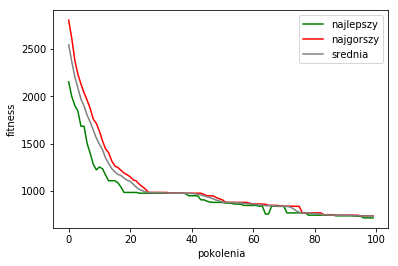

[(42, 28), (54, 46), (26, 27), (14, 13), (25, 38), (9, 29), (72, 28), (118, 34), (104, 40), (111, 22), (87, 59), (90, 71), (75, 70), (67, 77), (23, 88)]


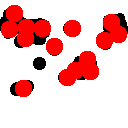

In [14]:
x = simulate(100, 12, 0.2, select_tournament, splitter_line, mutate_translate)
print(x)
draw_shops(x)

Pokolenia: 100  
Krzyżówki na pokolenie: 12  
Szansa na mutacje: 20%  
Wybór rodziców: lepszy z dwóch losowych  
Podział podczas krzyżowania: względem okręgu  
Mutacja: **losowanie**  

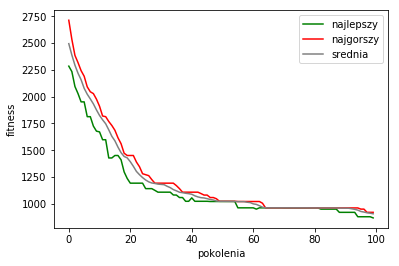

[(84, 66), (72, 76), (68, 26), (36, 69), (41, 34), (53, 50), (20, 84), (106, 34), (118, 21), (116, 36), (11, 21), (16, 34), (30, 39), (26, 21), (41, 27)]


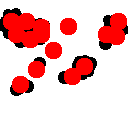

In [15]:
x = simulate(100, 12, 0.2, select_tournament, splitter_circle, mutate_random)
print(x)
draw_shops(x)

Pokolenia: 100  
Krzyżówki na pokolenie: 12  
Szansa na mutacje: **50%**  
Wybór rodziców: lepszy z dwóch losowych  
Podział podczas krzyżowania: względem okręgu  
Mutacja: dodawanie wektora  

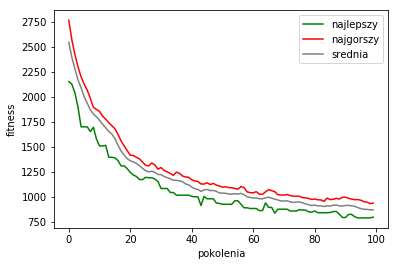

[(88, 63), (107, 42), (119, 22), (117, 32), (36, 66), (20, 89), (30, 34), (13, 30), (21, 23), (38, 25), (57, 48), (10, 18), (74, 72), (70, 26), (108, 23)]


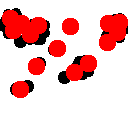

In [16]:
x = simulate(100, 12, 0.5, select_tournament, splitter_circle, mutate_translate)
print(x)
draw_shops(x)